Learning from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

using USD_INR exchange rate data

In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Basic LSTM (Not realistic because only next point prediction available)

In [213]:
dat = pd.read_csv('USD_INR.csv')

In [25]:
dat.head()

,Date,Price,Open,High,Low,Change %
0,"Aug 10, 2017",64.165,63.898,64.175,63.855,0.48
1,"Aug 09, 2017",63.860,63.780,63.860,63.710,0.26
2,"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23
3,"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
4,"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05


In [26]:
p_dat = dat[['Date','Price']]
p_dat['Date'] = pd.to_datetime(p_dat['Date'])

/Users/y0w0252/my-python/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
p_dat = p_dat.sort_values('Date',ascending=True)

In [28]:
p_dat.head()

,Date,Price
9696,1980-01-02,8.00
9695,1980-01-03,7.95
9694,1980-01-04,8.05
9693,1980-01-07,8.05
9692,1980-01-08,8.05


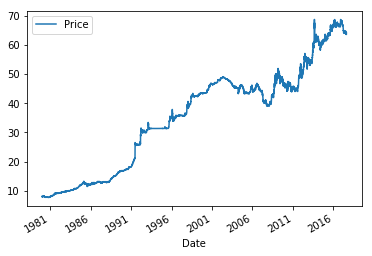

In [32]:
p_dat.plot(x='Date',y='Price')

In [33]:
price_dat = p_dat['Price']

In [34]:
price_dat.head()

9696    8.00
9695    7.95
9694    8.05
9693    8.05
9692    8.05
Name: Price, dtype: float64

In [35]:
print(np.mean(price_dat.values))
print(np.std(price_dat.values))

35.5577077447
17.540190695


### Normalize

In [36]:
price_dat = price_dat.values.ravel().reshape(-1,1)

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_dat = scaler.fit_transform(price_dat)

In [38]:
print(np.mean(price_dat))
print(np.std(price_dat))

0.456077018318
0.286956084989


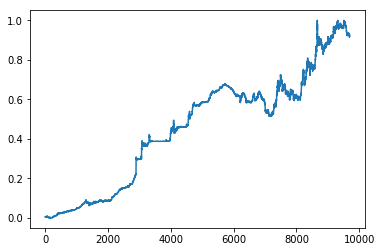

In [39]:
plt.plot(price_dat)

### Train Test Split

In [304]:
ratio = int(round(len(price_dat)*0.8))
print(ratio)

7758


In [305]:
train_dat = price_dat[:ratio]
valid_dat = price_dat[ratio:]

### Creating look back dataset:

In [306]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] # if look_back=1, look back 1 datapoint,  if look_back=2, look back 2 datapoints
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) # the next point from the look back points
    return np.array(dataX), np.array(dataY)

In [307]:
# reshape into X=t and Y=t+1
look_back = 1 # using past 1 value to predict the next

trainX, trainY = create_dataset(train_dat, look_back)
testX, testY = create_dataset(valid_dat, look_back)

In [308]:
print(trainX.shape)
print(trainY.shape)

(7756, 1)
(7756,)


In [309]:
trainX[:5,:]

array([[ 8.  ],
       [ 7.95],
       [ 8.05],
       [ 8.05],
       [ 8.05]])

In [310]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [311]:
print(trainX.shape)


(7756, 1, 1)


In [313]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


KeyboardInterrupt: 

### Predict in-sample and out-sample

In [ ]:
res_insp = model.predict(trainX)
res_outsp = model.predict(testX)

In [ ]:
# inverse the transformation back to get the true value:
res_insp = scaler.inverse_transform(res_insp)
trainY = scaler.inverse_transform([trainY])

res_outsp = scaler.inverse_transform(res_outsp)
testY = scaler.inverse_transform([testY])

In [51]:
# RMSE:

trainScore = math.sqrt(mean_squared_error(trainY[0], res_insp[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], res_outsp[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 0.99 RMSE


In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_dat)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(res_insp)+look_back, :] = res_insp
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_dat)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(res_insp)+(look_back*2)+1:len(price_dat)-1, :] = res_outsp
# plot baseline and predictions

#### Original Data:

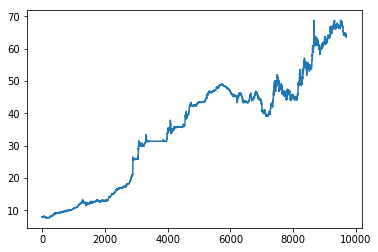

In [53]:

plt.plot(scaler.inverse_transform(price_dat))


#### In-sample Prediction:

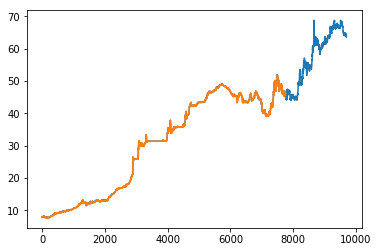

In [54]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(trainPredictPlot)


#### Out-sample Prediction:

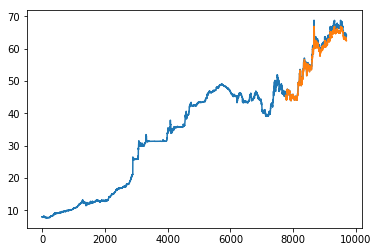

In [55]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(testPredictPlot)

# New Method, prediction and keep rolling

In [314]:
dat = pd.read_csv('USD_INR.csv')

In [315]:
# Right order
p_dat = dat[['Date','Price']]
p_dat['Date'] = pd.to_datetime(p_dat['Date'])
p_dat = p_dat.sort_values('Date',ascending=True)
price_dat = p_dat['Price']
print(price_dat.shape)

(9697,)


/Users/y0w0252/my-python/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [316]:
# Price data
price_dat = price_dat.values.ravel().reshape(-1,1)

In [317]:
#Normalize:
scaler = MinMaxScaler(feature_range=(0, 1))
price_dat = scaler.fit_transform(price_dat)


In [318]:
ratio = int(round(len(price_dat)*0.8))

train_dat = price_dat[:ratio]

valid_dat = price_dat[ratio:]

In [319]:
print(len(train_dat))
print(len(valid_dat))

7758
1939


In [320]:
# convert an array of values into a dataset matrix
def create_train(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)] # if look_back=1, look back 1 datapoint,  if look_back=2, look back 2 datapoints
        dataX.append(a)

        dataY.append(dataset[i + look_back]) # the next point from the look back points
    print(len(dataX))
    return np.array(dataX), np.array(dataY)

In [321]:
# reshape into X=t and Y=t+1
look_back = 7 # using past 1 value to predict the next
trainX, trainY = create_train(train_dat, look_back)


7751


In [322]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print(trainX.shape)
print(trainY.shape)

(7751, 1, 7)
(7751, 1)


In [323]:
# create and fit the LSTM network
# Best so far: 7.9--- 7,4,100,10
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
 - 5s - loss: 0.0060
Epoch 2/100
 - 4s - loss: 2.8514e-05
Epoch 3/100
 - 4s - loss: 2.1924e-05
Epoch 4/100
 - 4s - loss: 2.0890e-05
Epoch 5/100
 - 4s - loss: 2.1860e-05
Epoch 6/100
 - 4s - loss: 2.1277e-05
Epoch 7/100
 - 4s - loss: 2.1592e-05
Epoch 8/100
 - 4s - loss: 2.2173e-05
Epoch 9/100
 - 4s - loss: 2.1227e-05
Epoch 10/100
 - 4s - loss: 1.9856e-05
Epoch 11/100
 - 4s - loss: 2.0908e-05
Epoch 12/100
 - 4s - loss: 1.8940e-05
Epoch 13/100
 - 4s - loss: 1.7186e-05
Epoch 14/100
 - 4s - loss: 1.7236e-05
Epoch 15/100
 - 4s - loss: 1.6802e-05
Epoch 16/100
 - 4s - loss: 1.7186e-05
Epoch 17/100
 - 4s - loss: 1.5160e-05
Epoch 18/100
 - 4s - loss: 1.5055e-05
Epoch 19/100
 - 4s - loss: 1.4870e-05
Epoch 20/100
 - 4s - loss: 1.3716e-05
Epoch 21/100
 - 4s - loss: 1.2991e-05
Epoch 22/100
 - 4s - loss: 1.2773e-05
Epoch 23/100
 - 4s - loss: 1.2365e-05
Epoch 24/100
 - 4s - loss: 1.2277e-05
Epoch 25/100
 - 4s - loss: 1.1856e-05
Epoch 26/100
 - 4s - loss: 1.1083e-05
Epoch 27/100
 - 4s - loss

In [324]:
data=price_dat
ratio=ratio
look_back = look_back
temp_train = data[:ratio]




In [325]:


for i in range(len(data)-len(data[:ratio])):


    testX_temp =  temp_train[(-look_back):]
    testX_temp = np.reshape(testX_temp, (1, 1, look_back))
    pred = model.predict(testX_temp)
    temp_train = np.append(temp_train,pred).reshape(-1,1)
    print('Predicted: {}'.format(pred))




Predicted: [[ 0.62469441]]
Predicted: [[ 0.62705356]]
Predicted: [[ 0.63043362]]
Predicted: [[ 0.63385421]]
Predicted: [[ 0.63753474]]
Predicted: [[ 0.64137214]]
Predicted: [[ 0.6451686]]
Predicted: [[ 0.64897555]]
Predicted: [[ 0.65282643]]
Predicted: [[ 0.6566835]]
Predicted: [[ 0.66054517]]
Predicted: [[ 0.66440576]]
Predicted: [[ 0.66826683]]
Predicted: [[ 0.67212659]]
Predicted: [[ 0.6759823]]
Predicted: [[ 0.67983258]]
Predicted: [[ 0.68367636]]
Predicted: [[ 0.68751246]]
Predicted: [[ 0.69133955]]
Predicted: [[ 0.69515628]]
Predicted: [[ 0.69896162]]
Predicted: [[ 0.70275426]]
Predicted: [[ 0.70653284]]
Predicted: [[ 0.71029621]]
Predicted: [[ 0.7140432]]
Predicted: [[ 0.71777254]]
Predicted: [[ 0.72148401]]
Predicted: [[ 0.72517776]]
Predicted: [[ 0.72885191]]
Predicted: [[ 0.73250544]]
Predicted: [[ 0.73613727]]
Predicted: [[ 0.73974615]]
Predicted: [[ 0.74333102]]
Predicted: [[ 0.74689066]]
Predicted: [[ 0.75042397]]
Predicted: [[ 0.75392967]]
Predicted: [[ 0.75740665]]
Predi

Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
P

Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
P

Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
P

Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
Predicted: [[ 0.92566508]]
P

In [326]:
temp_train.shape

(9697, 1)

In [327]:
len(price_dat)

9697

In [328]:
# inverse the transformation back to get the true value:
temp_train = scaler.inverse_transform(temp_train)
price_dat = scaler.inverse_transform(price_dat)



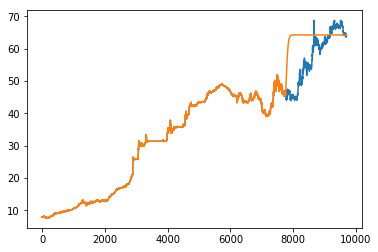

In [329]:
plt.plot(price_dat)
plt.plot(temp_train)

In [301]:
# RMSE:

def rmse(x,y):
    
    
    return np.sqrt(np.mean(np.power(x-y,2)))

In [302]:
temp_train[ratio:].shape

(1939, 1)

In [303]:

rmse(price_dat[ratio:],temp_train[ratio:])

7.3318585605697351